### Network Science

In this effort, we will explore a dataset that shows which organization each entry is a member of. We will represent this kind of data as a network and explore the various nodes comprising this network.

### Code

In [58]:
# Load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import networkit as nk
import community.community_louvain as community_louvain

from collections import defaultdict
from itertools import combinations
from networkx.algorithms import bipartite

Let's get the dataset in here and check it out.

In [4]:
# Load data in 
df = pd.read_csv("organization.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10598 entries, 0 to 10597
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Organisation  10598 non-null  object
 1   member        9652 non-null   object
dtypes: object(2)
memory usage: 165.7+ KB
None
  Organisation                 member
0     ethereum          Oleh Aldekein
1     ethereum                    NaN
2     ethereum     Frank Szendzielarz
3     ethereum      Kolby Moroz Liebl
4     ethereum  Marius van der Wijden


We have 10,598 entries in this dataset consisting of just two columns - `Organisation` and `member`. However, there appears to be some missing data points in the `member` variable that may need to be addressed.

In [6]:
# Find number of missing values 
nans_per_column = df.isna().sum()
print(nans_per_column)

Organisation      0
member          946
dtype: int64


There are 946 entries in this dataset that consist of only a value for the `Organisation` variable, but no corresponding name. Let's remove these rows from the dataframe.

In [8]:
# Drop all rows with NaN value
df = df.dropna()
total_nans = df.isna().sum().sum()
print(f"Total NaN values in DataFrame: {total_nans}")

Total NaN values in DataFrame: 0


Good - all of the missing values have been removed from the dataset. Let's move onto building the network.

### Identify Key Developers

To identify the developers connected to the most organizations or act as key connectors between organizations, I will calculate the betweenness centrality. This is a measure of how often each node lies on the shortest path between nodes and will help to reveal the most strategically positioned developers in the network.

In [12]:
# Build network
B = nx.Graph()
B.add_nodes_from(df['Organisation'], bipartite='Organisation')
B.add_nodes_from(df['member'], bipartite='member')
edges = list(df.itertuples(index=False, name=None))
B.add_edges_from(edges)

In [13]:
# Compute betweenness centrality and output key connectors
betweenness = nx.betweenness_centrality(B)
members = df['member'].unique()
member_betweenness = {node: betweenness[node] for node in members}
betweenness_df = pd.DataFrame.from_dict(member_betweenness, orient='index', columns=['betweenness'])
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)

# Check out top 5 connecting members
print(betweenness_df.head(5))

               betweenness
Daniel            0.039725
Ryan Wilson       0.029212
Glaucia Lemos     0.023724
Seth              0.023546
Yegor             0.023546


It appears that the top five key developers (connectors) between organizations are:
- Daniel
- Ryan Wilson
- Glaucia Lemos
- Seth
- Yegor

Some of these developers are so well-known they do not even need a last name to be recognized.

### Most Popular Organization

To identify the organizations that attract the most developers, we can compute the degree centrality of each organizational node.

In [18]:
# Calculate degree centrality for organizational nodes
degree_dict = dict(B.degree())
organizations = df['Organisation'].unique()
org_degrees = {node: degree_dict[node] for node in organizations}
org_degree_df = pd.DataFrame.from_dict(org_degrees, orient='index', columns=['num_developers'])
org_degree_df = org_degree_df.sort_values(by='num_developers', ascending=False)
print(org_degree_df.head(5))

           num_developers
microsoft            3916
Azure                1616
apache               1074
google                802
nodejs                363


The organization that attracts the most developers is by far Microsoft, which has a degree centrality of 3916. This is over twice the amount of developers of the second place organization. Following behind Microsoft, there is Azure, Apache, Google, and Node JS.

### Organizational Collaboration

To identify which organizations are best positioned to facilitate collaboration between developers of different organizations, we need to first create a new network of just developers. Developer nodes will be connected if they share an organization. Then, we can compute the betweenness centrality of this developer network and track the organizations responsible for connecting the nodes. 

In [30]:
# Create developer network 
members = df['member'].unique()
dev_graph = bipartite.weighted_projected_graph(B, members)

In [38]:
# Convert using Networkit (to speed up processing) and compute betweenness centrality
nk_graph = nk.nxadapter.nx2nk(dev_graph)
betweenness = nk.centrality.Betweenness(nk_graph, normalized=True)
betweenness.run()
scores = betweenness.scores()
nk_node_map = list(dev_graph.nodes())
dev_betweenness = {nk_node_map[i]: scores[i] for i in range(len(scores))}
member_to_orgs = df.groupby('member')['Organisation'].apply(set).to_dict()

In [40]:
# Show top five organizations
org_scores = defaultdict(float)
for dev, centrality in dev_betweenness.items():
    for org in member_to_orgs.get(dev, []):
        org_scores[org] += centrality

org_df = pd.DataFrame.from_dict(org_scores, orient='index', columns=['aggregate_betweenness'])
top_orgs = org_df.sort_values(by='aggregate_betweenness', ascending=False).head(5)
print(top_orgs)

           aggregate_betweenness
microsoft               0.658679
Azure                   0.306266
apache                  0.253703
google                  0.227969
nodejs                  0.136283


Very similar to the results we saw for the previous section. The organizations that are best positioned to facilitate collaboration between developers are:
- Microsoft
- Azure
- Apache
- Google
- Node JS 

### Clustering and Grouping

To identify groups of organizations that tend to collaborate with each other, we can build an organizational network where edges between nodes exist when two organizations share one or more developers. The weight of these edges will be representative of the number of shared developers. Then, we will run a Louvain algorithm to highlight the clustering of organizations/nodes.

In [51]:
# Create organizational graph
B = nx.Graph()
B.add_nodes_from(df['member'], bipartite='member')
B.add_nodes_from(df['Organisation'], bipartite='org')
B.add_edges_from(list(df.itertuples(index=False, name=None)))
org_graph = nx.Graph()
member_to_orgs = df.groupby('member')['Organisation'].apply(set)
edge_weights = defaultdict(int)

for orgs in member_to_orgs:
    if len(orgs) < 2:
        continue  
    for org1, org2 in combinations(sorted(orgs), 2):
        edge_weights[(org1, org2)] += 1
        
for (org1, org2), weight in edge_weights.items():
    org_graph.add_edge(org1, org2, weight=weight)

              community
Azure                 0
microsoft             0
mongodb               0
ethereum              0
grafana               1
prometheus            1
ansible               1
golang                1
deepmind              1
freeCodeCamp          1
firebase              1
flutter               1
python                1
django                1
google                1
rails                 2
reduxjs               2
serverless            2
pytorch               2
elastic               2
nuxt                  2
NVIDIA                2
apache                2
babel                 2
atom                  2
jquery                2
facebook              2
reactjs               2
nodejs                2
huggingface           2
aws                   2
vuejs                 2
graphql               2


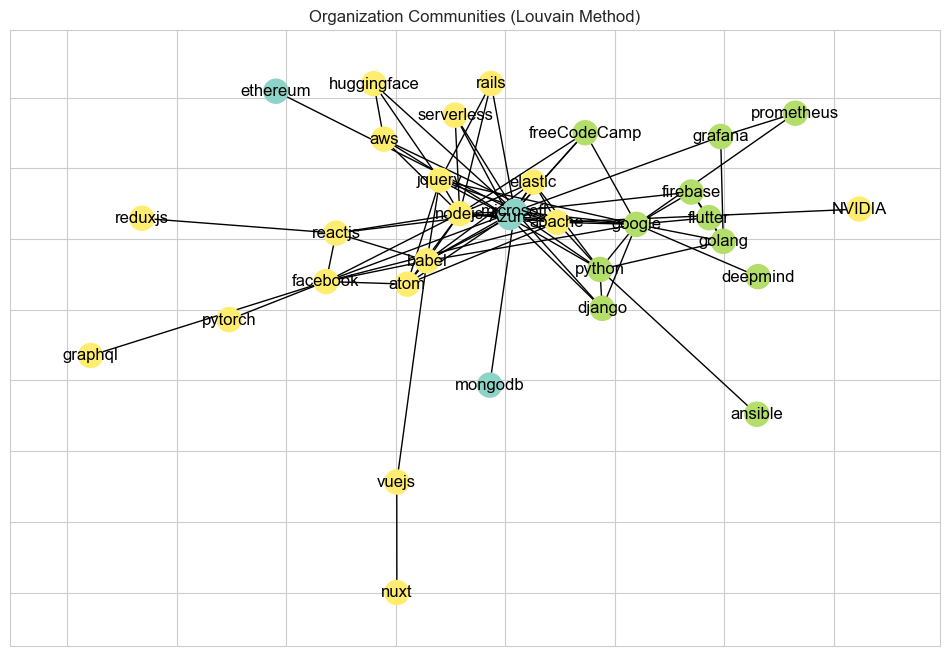

In [80]:
# Run Louvain algorithm and output communities
partition = community_louvain.best_partition(org_graph, weight='weight')
org_communities = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])
org_communities = org_communities.sort_values('community')
print(org_communities)

# Visualize clusters
pos = nx.spring_layout(org_graph, seed=42)
colors = [partition[node] for node in org_graph.nodes()]
plt.figure(figsize=(12, 8))
nx.draw_networkx(org_graph, pos, node_color=colors, with_labels=True, node_size=300, cmap=plt.cm.Set3)
plt.title("Organization Communities (Louvain Method)")
plt.show()

From this output, we can see there are really only three different clusters in this organizational network, which are labeled as Community 0, 1, and 2. In the visual, Community 0 is represented by the blue(ish?) nodes, Community 1 is represented by the green nodes, and Community 2 is represented by the yellow nodes. If we cross reference these results with the earlier observations, we can see that the Community 0 consists of the more popular "hub" organizations (like Microsoft and Apache) with the highest amount of organizational collaboration. It seems as if all roads run through Commmunity 0.mmunity : 2 (Yellow)

### Influential Developer Identification

To identify which developers hold the most influence in the network, we can determine which developers are connected to the most important ones - quality, not just quantity. Through the use of eigenvector centrality, we will be able to rank the developers based on their connections to other high ranking (influential) developers. We already created the developer network earlier, so we can just leverage our previous work.

In [94]:
# Calculate eigenvector centrality and output top 5
eigen_centrality = nx.eigenvector_centrality(dev_graph, weight='weight', max_iter=1000)
eigen_df = pd.DataFrame.from_dict(eigen_centrality, orient='index', columns=['eigenvector'])
eigen_df = eigen_df.sort_values(by='eigenvector', ascending=False)
print(eigen_df.head(5))

                             eigenvector
Lucas Santos                    0.018894
Darcy Clarke                    0.018894
Sergey Grebnov                  0.018884
Dr Christian Geuer-Pollmann     0.018884
Strong Liu(刘少壮)                 0.018884


In this network, the top five most influential developers appear to be:
- Lucas Santos
- Darcy Clarke
- Sergey Grebnov
- Dr. Christian Geuer-Pollman
- Strong Liu